Copyright **`(c)`** 2024 Gabriele Mancari Pasi `<s323387@studenti.polito.it>`  

# Lab2 - TSP

In [10]:
from itertools import combinations, accumulate
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.set_loglevel('ERROR')

In [11]:
CITIES_LIST = [('cities/italy.csv', 'italy'), ('cities/vanuatu.csv', 'vanuatu'), ('cities/russia.csv', 'russia'), ('cities/us.csv', 'us'), ('cities/china.csv', 'china')]
# the TSP_COSTS dict will store the costs obtained by using three different approaches: greedy approach, EA with segment crossover, EA with Inver-Over
TSP_COSTS = { CITIES_LIST[0][1]: [], CITIES_LIST[1][1]: [], CITIES_LIST[2][1]: [], CITIES_LIST[3][1]: [], CITIES_LIST[4][1]: [] }

In [12]:
def read_df(file_name):
    CITIES = pd.read_csv(file_name, header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    CITIES.head()
    return CITIES, DIST_MATRIX

In [13]:
def tsp_cost(CITIES, DIST_MATRIX, tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## Greedy Algorithm

In [14]:
def greedy_algorithm(CITIES, DIST_MATRIX):
    """
    This function implements a Greedy Algorithm; this approach starts from the first city and repeatedly visits the closest unvisited city until all cities are visited
    Finally, it returns to the starting city to complete the tour
    """
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    tsp.append(tsp[0])
    
    return tsp

In [15]:
def generate_map(CITIES, tsp, file_name, algorithm):
    """
    This function generates a map visualizing the path defined by the TSP solution
    It computes the center of the route and creates markers for each city in the path
    Finally, it draws a line to represent the route on the map.
    """
    tsp_path = CITIES.iloc[tsp]

    map_center = [tsp_path['lat'].mean(), tsp_path['lon'].mean()]

    zoom = 5
    if len(tsp) <= 10:
        zoom = 7
    elif len(tsp) <= 50:
        zoom = 6
    else:
        zoom = 4
    map = folium.Map(location=map_center, zoom_start=zoom)

    for idx, row in tsp_path.iterrows():
        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=row['name'],
            tooltip=row['name']
        ).add_to(map)

    coordinates = [(row['lat'], row['lon']) for idx, row in tsp_path.iterrows()]
    folium.PolyLine(coordinates, color="blue", weight=2.5, opacity=1).add_to(map)

    map.save("maps/tsp_{}_{}_map.html".format(algorithm, file_name))

In [16]:
def plot_map(CITIES, tsp):
    """
    This function plots the route defined by the TSP solution
    Latitude, longitude and names of the cities involved in the TSP path are extracted from the dataframe
    Then, the function creates a plot displaying the route as a line connecting the cities in the path
    """
    cities = CITIES.loc[tsp]
    latitudes = cities['lat'].values
    longitudes = cities['lon'].values
    city_names = cities['name'].values

    plt.figure(figsize=(14, 12))

    plt.plot(longitudes, latitudes, linestyle='-', color='#1E90FF', linewidth=2)
    plt.scatter(longitudes, latitudes, color='#00008B', s=50)

    for i, city in enumerate(city_names):
        plt.text(longitudes[i], latitudes[i], city, fontsize=10, ha='right')

    plt.title('TSP')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

In [17]:
def plot_cost(history, title):
    """
    This function plots the evolution of TSP minimum costs over generations.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, min)),
        color="red",
    )
    plt.title(str(title) + "; TSP costs")

    plt.show()

italy; final path of 46 steps; total length: 4436.03km


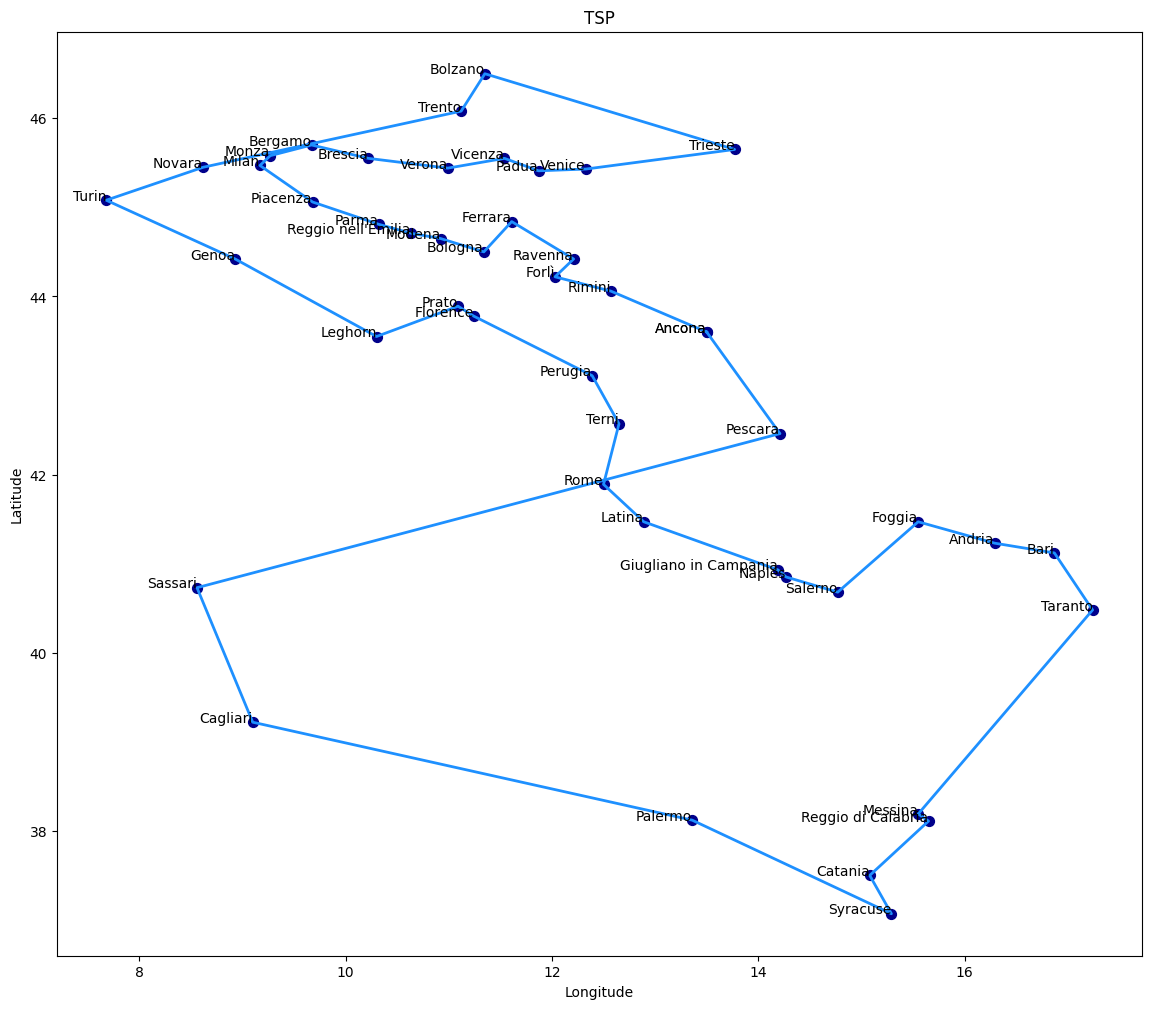

vanuatu; final path of 8 steps; total length: 1475.53km


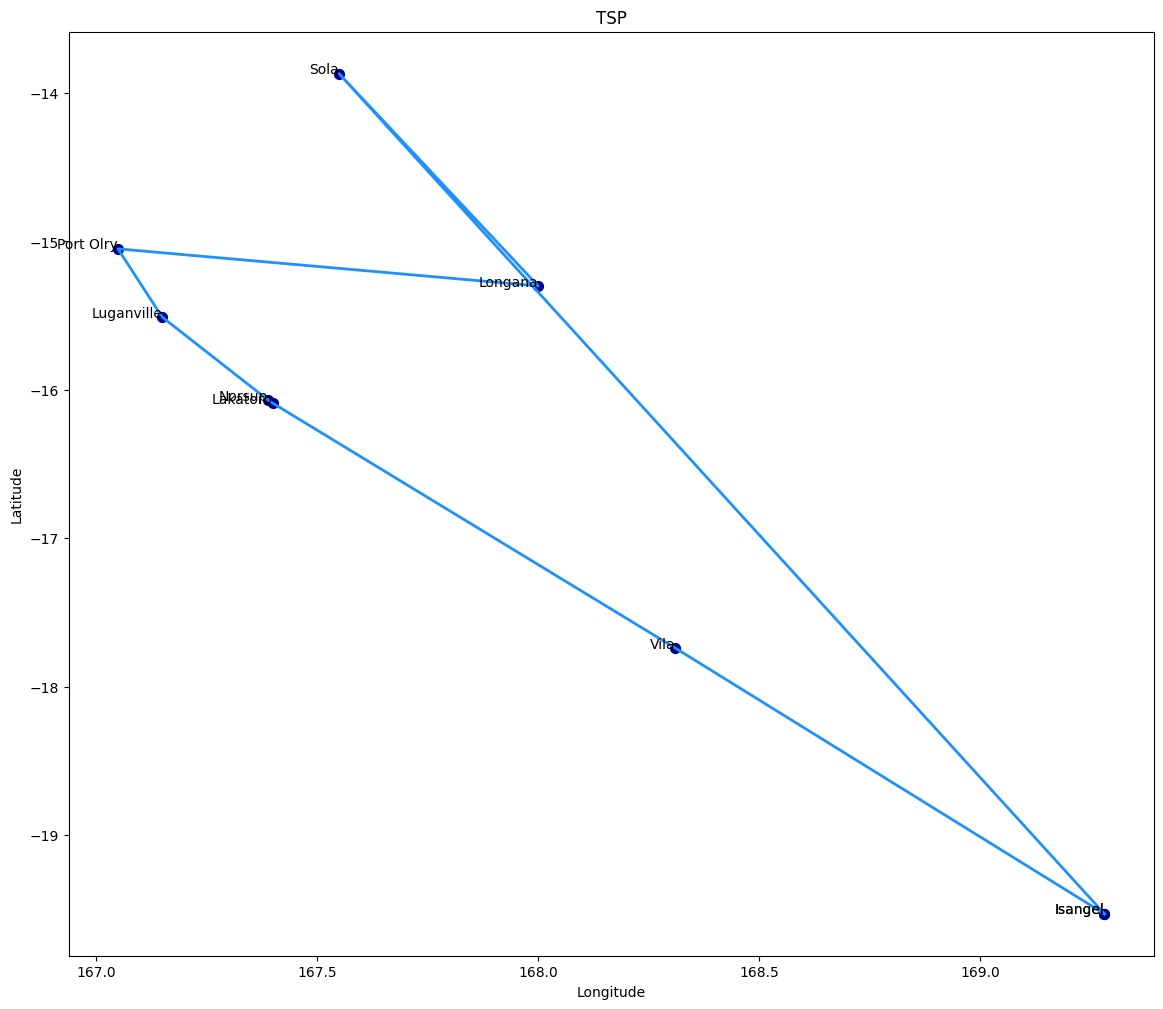

russia; final path of 167 steps; total length: 42334.16km


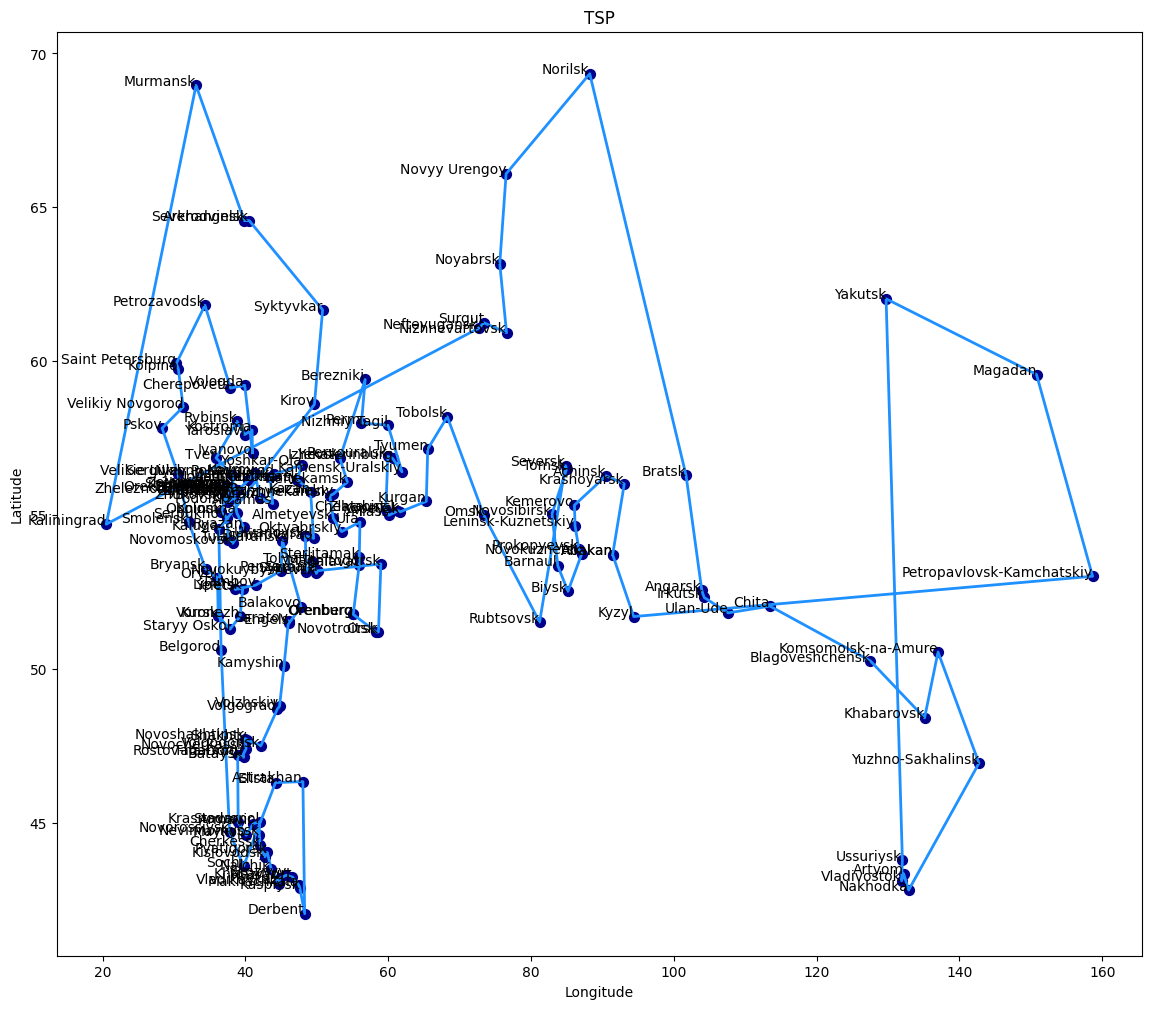

us; final path of 326 steps; total length: 48050.03km


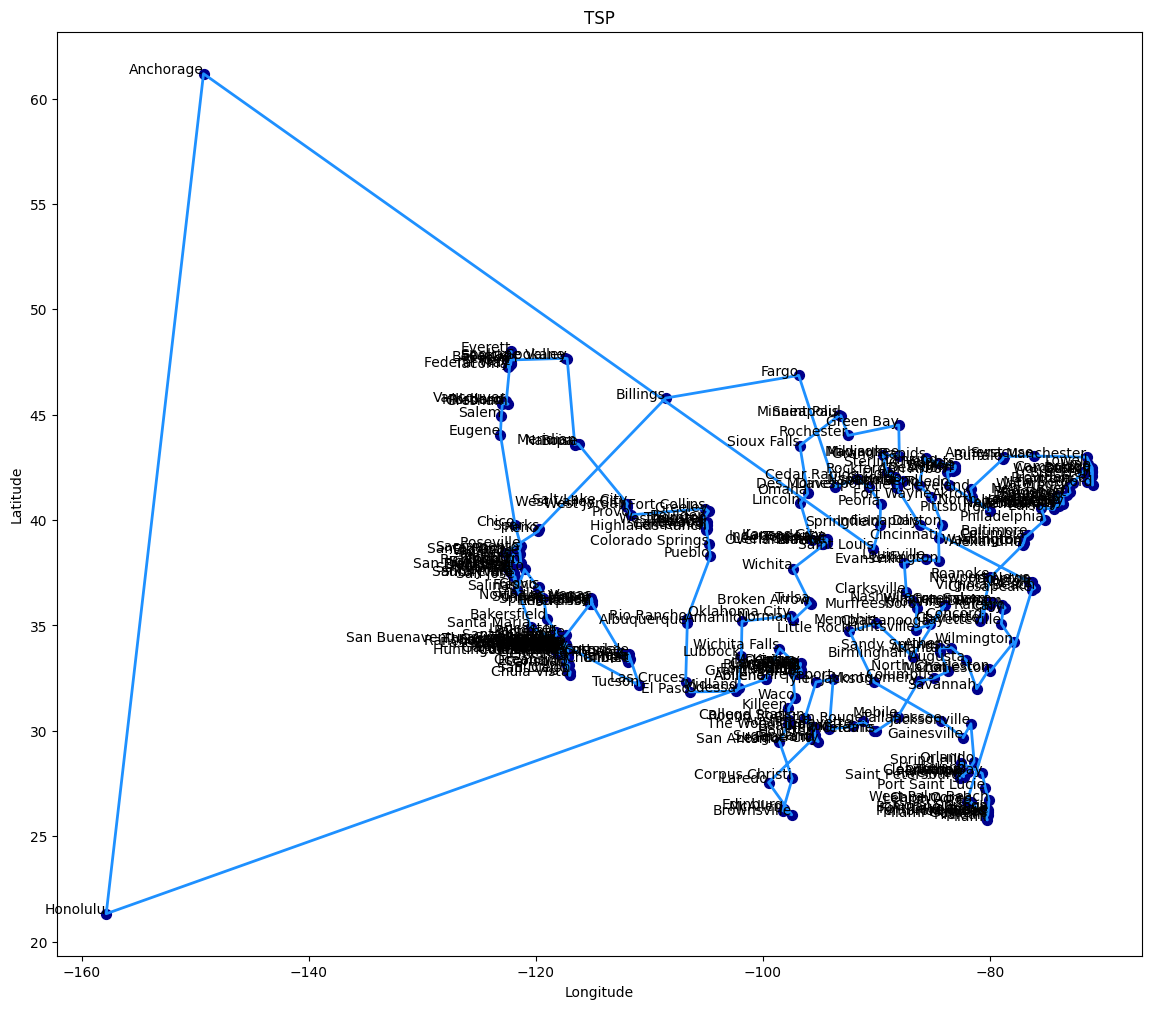

china; final path of 726 steps; total length: 63962.92km


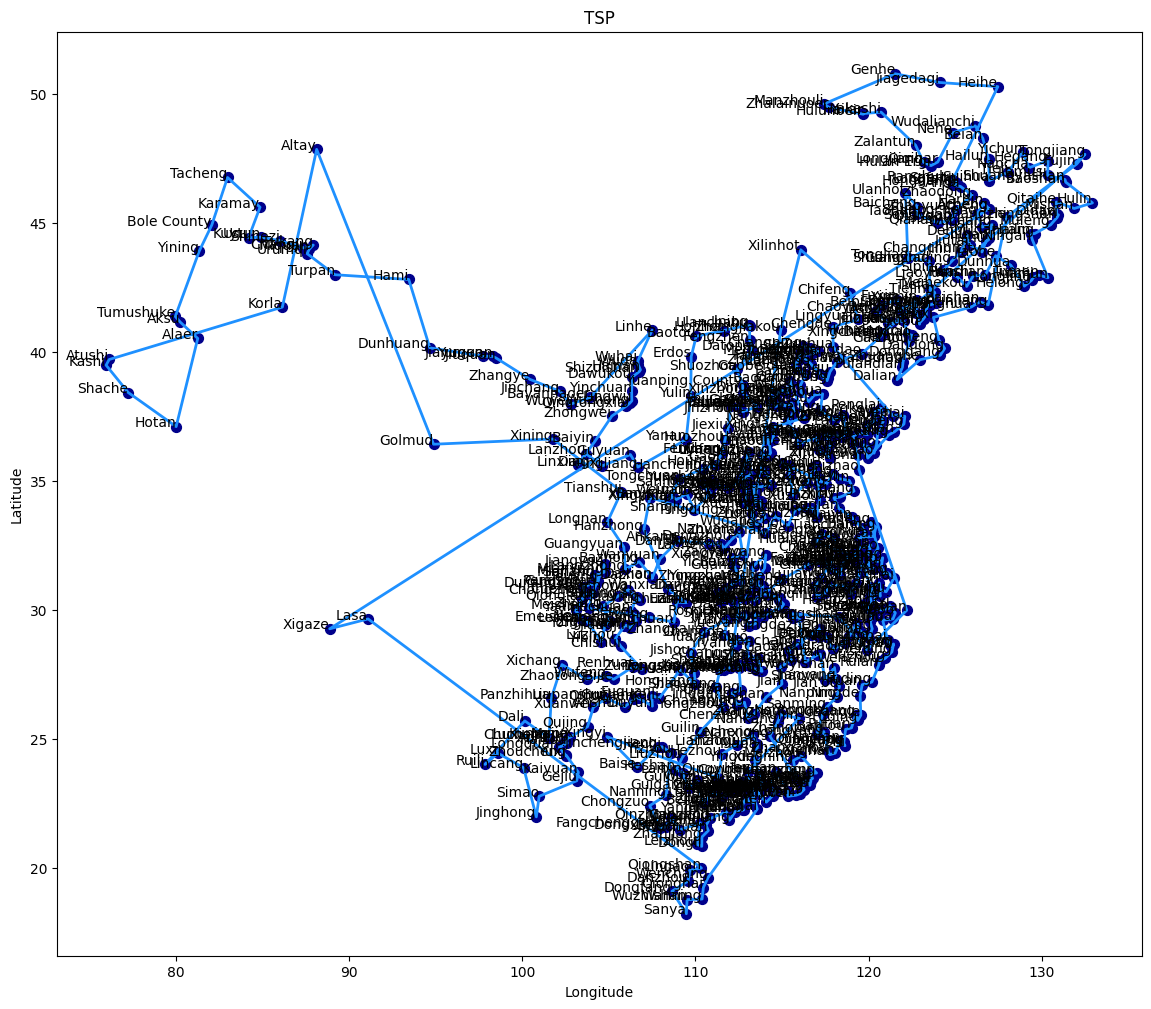

In [18]:
for name in CITIES_LIST:
    CITIES, DIST_MATRIX = read_df(name[0])
    tsp = greedy_algorithm(CITIES, DIST_MATRIX)
    cost = tsp_cost(CITIES, DIST_MATRIX, tsp)
    TSP_COSTS[name[1]].append(cost)

    print(f"{name[1]}; final path of {len(tsp)-1} steps; total length: {cost:.2f}km")
    generate_map(CITIES, tsp, name[1], "greedy")
    plot_map(CITIES, tsp)

## Evolutionary Algorithm

In [19]:
POPULATION_SIZE = 100
GENERATIONS = 1000
MUTATION_RATE = 0.1

In [20]:
def adjust_generations(num_cities):
    """
    This function changes the number of generations based on the number of cities
    For small datasets (20 or less), 500 generations are enough
    For medium datasets (more than 20 and up to 100), 1500 generations are used
    For large datasets (more than 100), 2500 generations are used
    """
    if num_cities <= 20:
        return 500
    elif 20 < num_cities <= 100:
        return 1500
    else:
        return 2500

In [21]:
def initialize_population(CITIES):
    """
    This function generates an initial population of random TSP routes
    """
    population = []
    for _ in range(POPULATION_SIZE):
        tsp = random.sample(range(len(CITIES)), len(CITIES))
        tsp.append(tsp[0])
        population.append(tsp)
    return population

In [22]:
def selection(CITIES, DIST_MATRIX, population):
    """
    This function calculates the cost for each path in the population, sorts them by the computed cost,
    and returns the top half as parents for the next generation.
    """
    costs = []
    for tsp in population:
        costs.append((tsp, tsp_cost(CITIES, DIST_MATRIX, tsp)))

    sorted_population = sorted(costs, key=lambda x: x[1])
    return [route for route, _ in sorted_population[:POPULATION_SIZE // 2]]

In [23]:
def crossover(parent1, parent2):
    """
    This function creates a child path by combining elements from parent1 and parent2.
    This function takes a segment from parent1 and fills the remaining spots in the child path with cities from parent2
    """
    child = [None] * len(parent1)

    start, end = sorted(random.sample(range(1, len(parent1) - 1), 2))
    child[start:end] = parent1[start:end]

    pointer = 0
    for city in parent2:
        if city not in child:
            while child[pointer] is not None:
                pointer += 1
            child[pointer] = city

    child[-1] = child[0]
    return child

In [24]:
def crossover_inver_over(parent1, parent2):
    """
    This function creates a child route using the Inver Over crossover method.
    This function selects a segment from parent1 and tries to maintain the edges by using
    a specific method to find the right edge from parent2. It then creates a child route
    by reversing the segment between the two selected points in parent1
    """
    child = [None] * len(parent1)

    start, end = sorted(random.sample(range(1, len(parent1) - 1), 2))
    left_edge = parent1[start]
    right_edge = parent1[end]
    for _ in range(150):
        index = parent2.index(left_edge)
        if parent2[index+1] == right_edge:
            break
        start, end = sorted(random.sample(range(1, len(parent1) - 1), 2))
        left_edge = parent1[start]
        right_edge = parent1[end]
    
    child[:start+1] = parent1[:start+1]
    child[start+1] = right_edge
    child[start+2:] = parent1[start+1:end][::-1]
    child[end+1:] = parent1[end+1:]

    child[-1] = child[0]
    return child

In [25]:
def mutation(tsp):
    """
    This function performs mutation on the TSP path by swapping two cities at random, based on the defined probability MUTATION_RATE
    """
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(len(tsp)-1), 2)
        tsp[i], tsp[j] = tsp[j], tsp[i]
        tsp[-1] = tsp[0]
    return tsp

In [26]:
def mutation_inversion(tsp):
    """
    This function applies Inversion mutation on the TSP path by reversing the order of a segment of cities,
    defined by two randomly selected indices, with a probability of MUTATION_RATE
    """
    if random.random() < MUTATION_RATE:
        start, end = sorted(random.sample(range(len(tsp)-1), 2))
        tsp[start:end+1] = tsp[start:end+1][::-1]
        tsp[-1] = tsp[0]
    return tsp

In [27]:
def evolutionary_algorithm(CITIES, DIST_MATRIX, v2=False):
    """
    This function implements an Evolutionary Algorithm; it initializes a population of possible paths,
    then iteratively selects parents, creates offspring using crossover and mutation methods and modifies the population.
    The best path and its cost are tracked throughout the generations and the final result is returned at the end of the process.
    """
    population = initialize_population(CITIES)
    best_tsp, best_cost = None, float('inf')
    history = []
    
    for _ in tqdm(range(GENERATIONS)):
        selected = selection(CITIES, DIST_MATRIX, population)

        offspring = []
        while len(offspring) < (POPULATION_SIZE):
            parent1, parent2 = random.sample(selected, 2)
            if (not v2): 
                child = crossover(parent1, parent2)
                child = mutation(child)
            else:
                child = crossover_inver_over(parent1, parent2)
                child = mutation_inversion(child)
            offspring.append(child)
        population = offspring
        
        for tsp in population:
            cost = tsp_cost(CITIES, DIST_MATRIX, tsp)
            if cost < best_cost:
                best_tsp, best_cost = tsp, cost
        
        history.append(best_cost)
    return best_tsp, best_cost, history

### EA with segment crossover and simple mutation

  0%|          | 0/1500 [00:00<?, ?it/s]

italy; final path of 46 steps; total length: 5643.24km


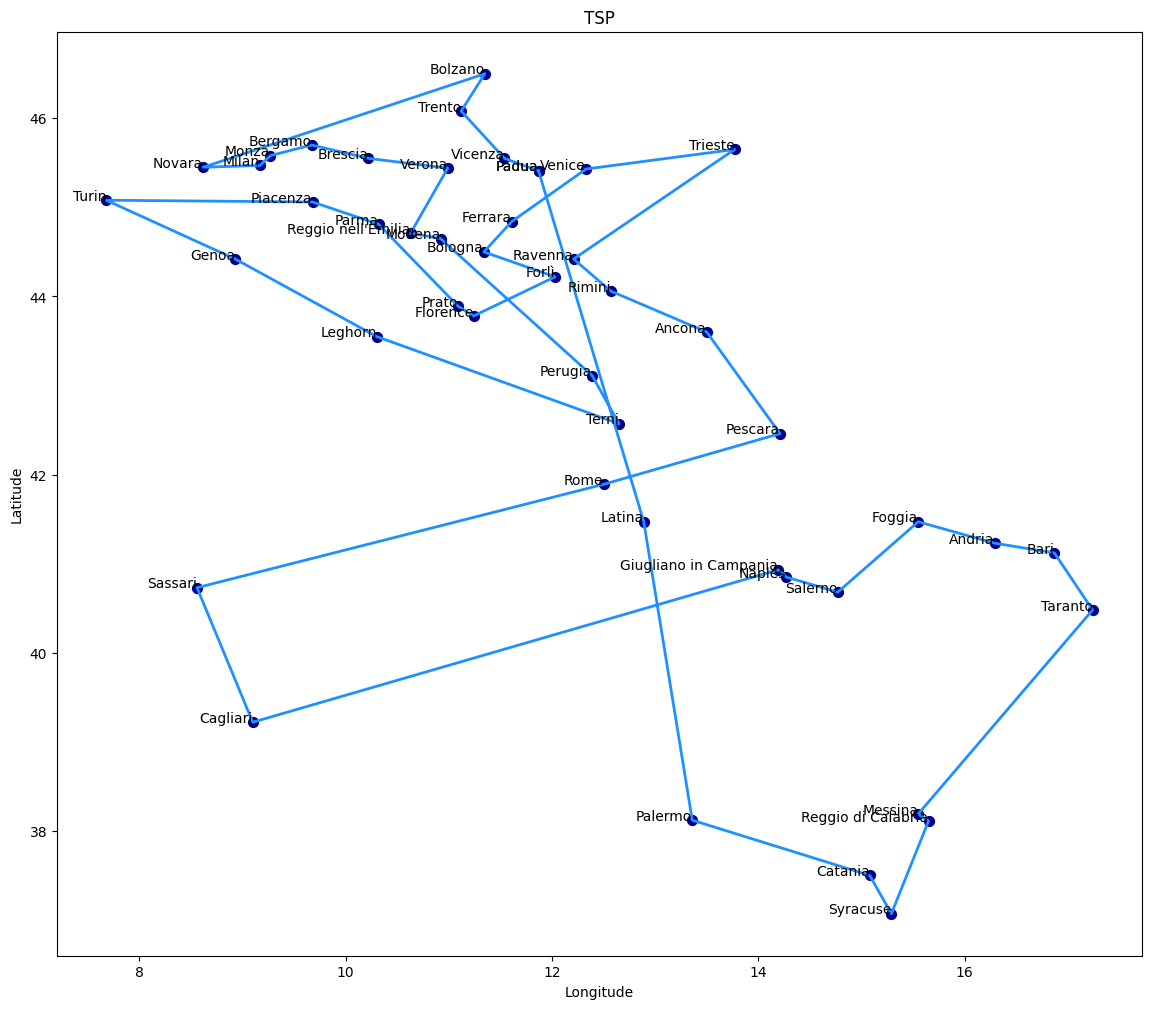

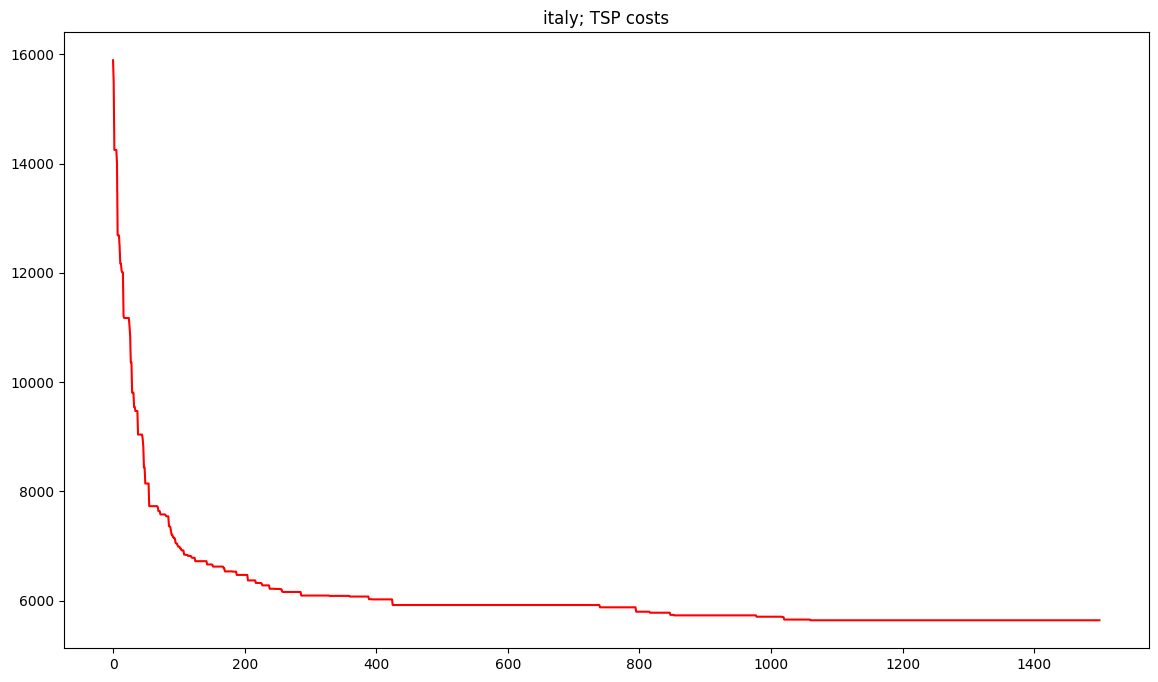

  0%|          | 0/500 [00:00<?, ?it/s]

vanuatu; final path of 8 steps; total length: 1345.54km


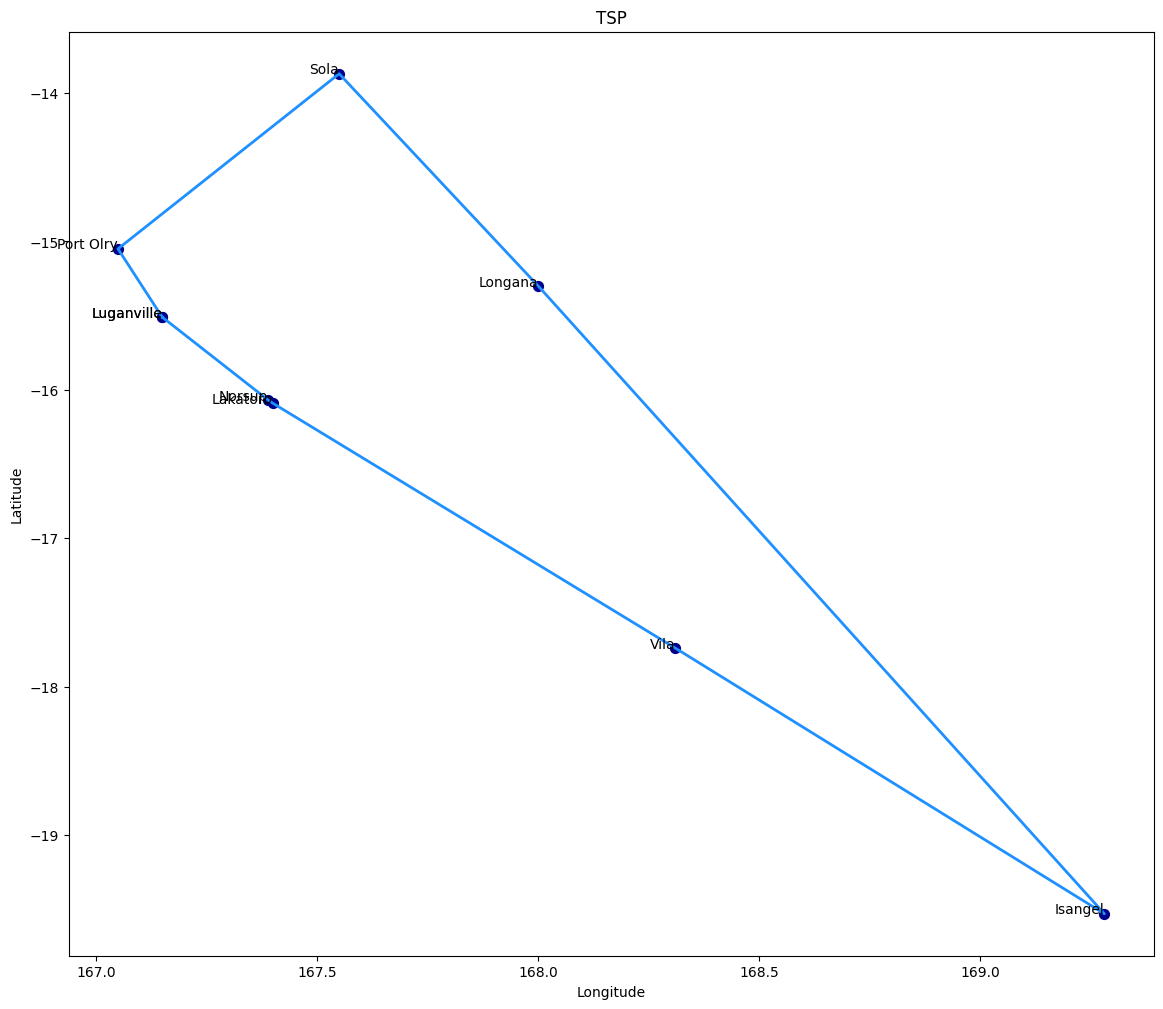

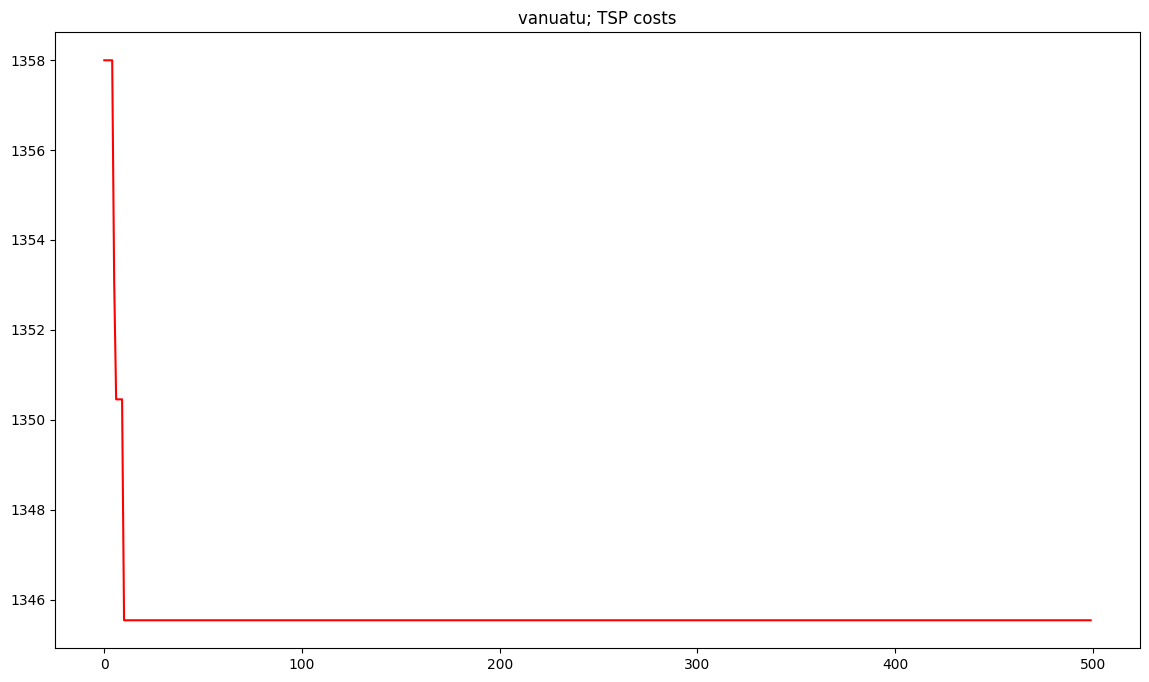

  0%|          | 0/2500 [00:00<?, ?it/s]

russia; final path of 167 steps; total length: 67685.22km


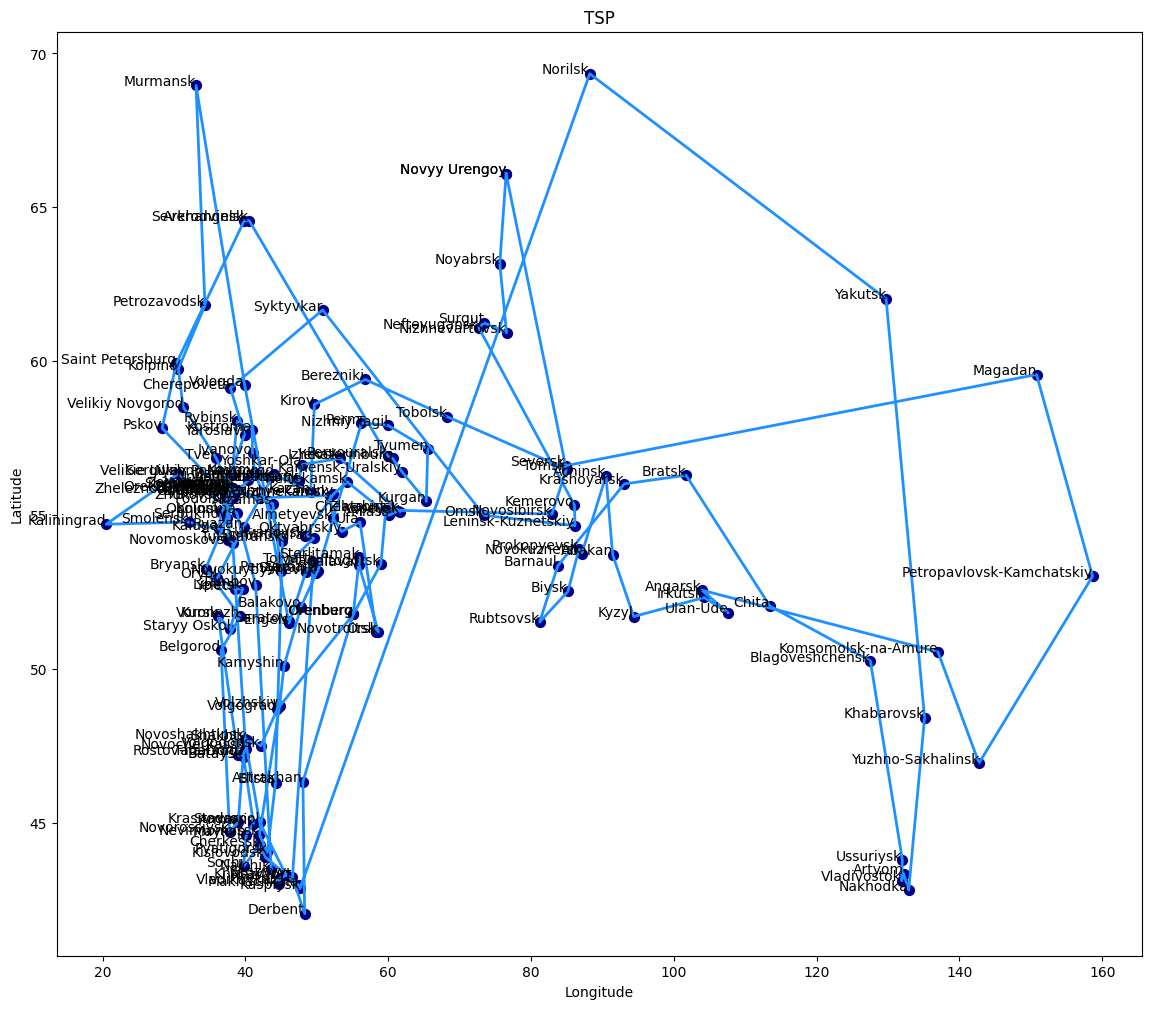

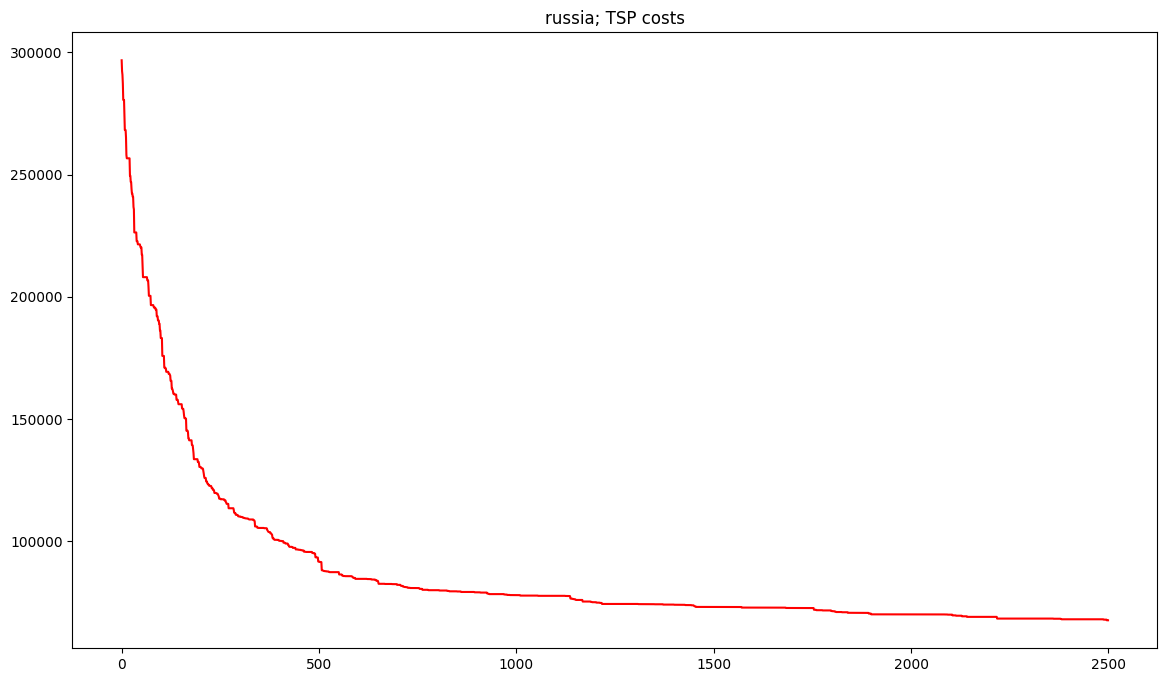

  0%|          | 0/2500 [00:00<?, ?it/s]

us; final path of 326 steps; total length: 167020.43km


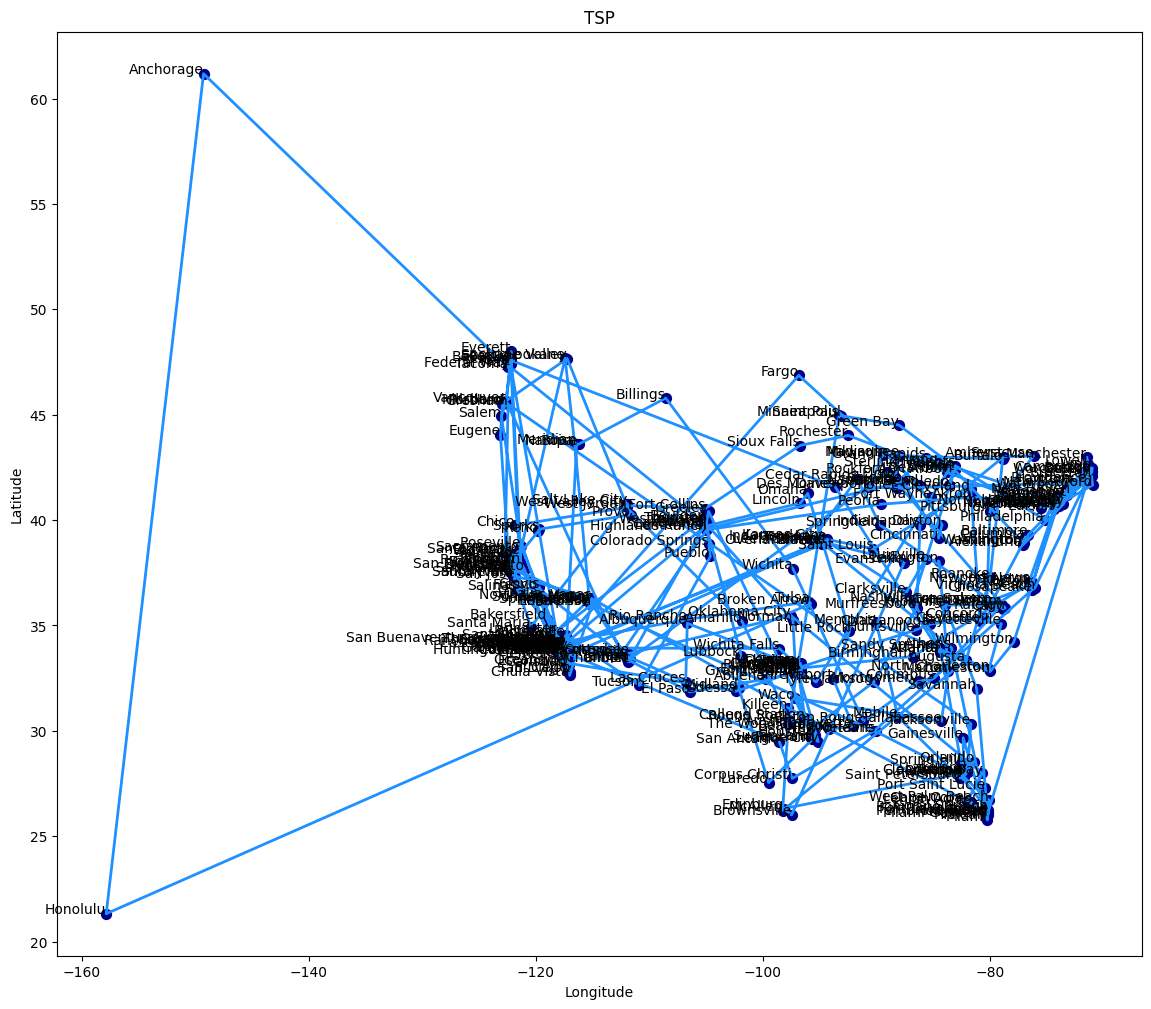

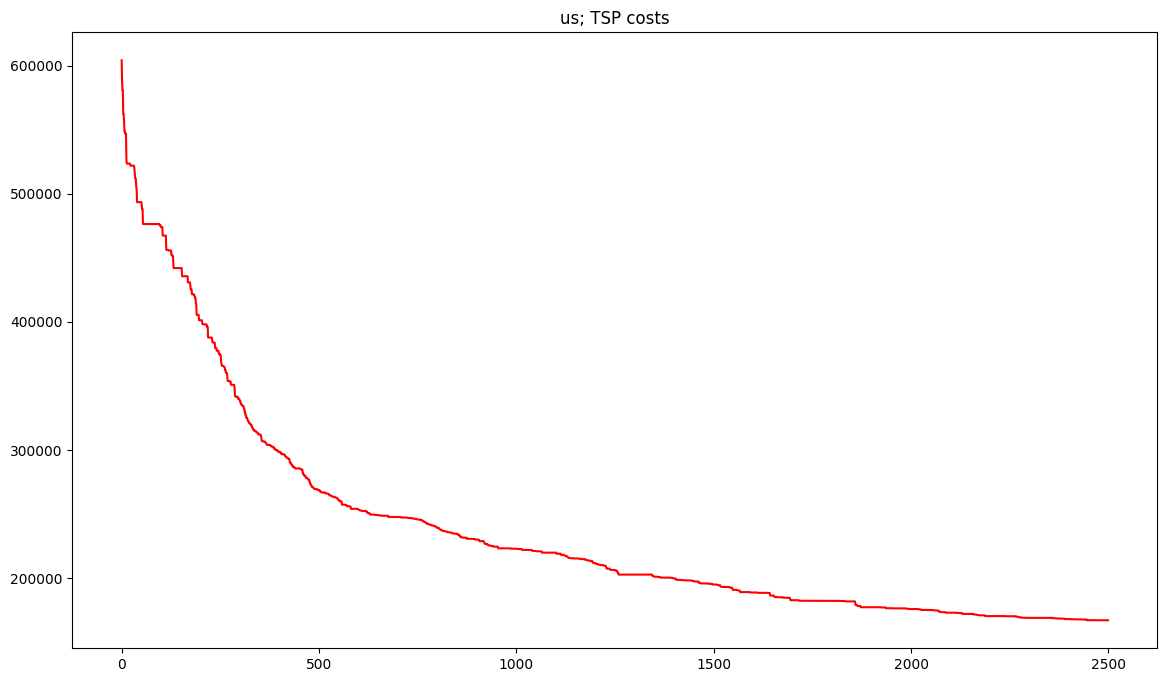

  0%|          | 0/2500 [00:00<?, ?it/s]

china; final path of 726 steps; total length: 362677.20km


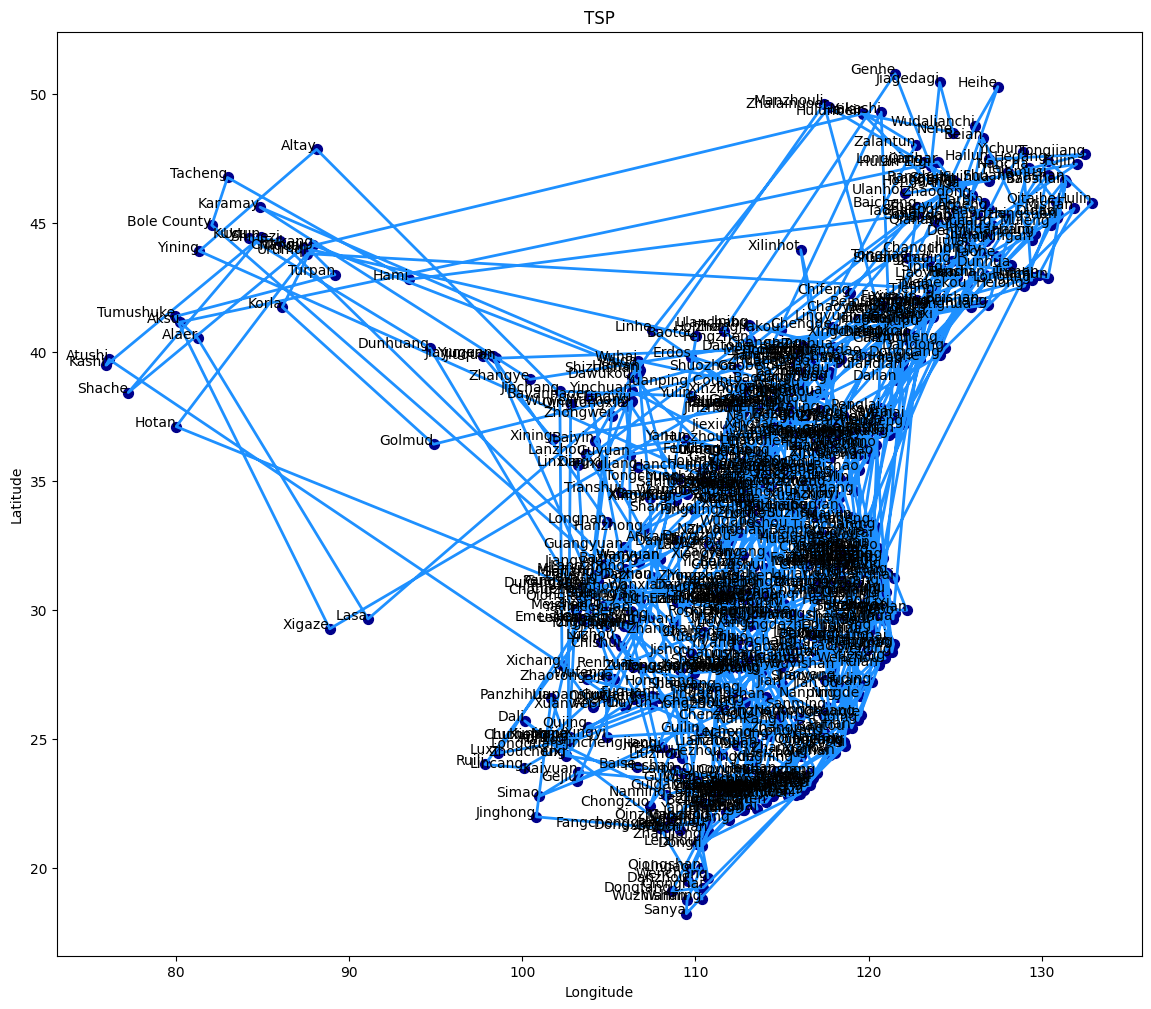

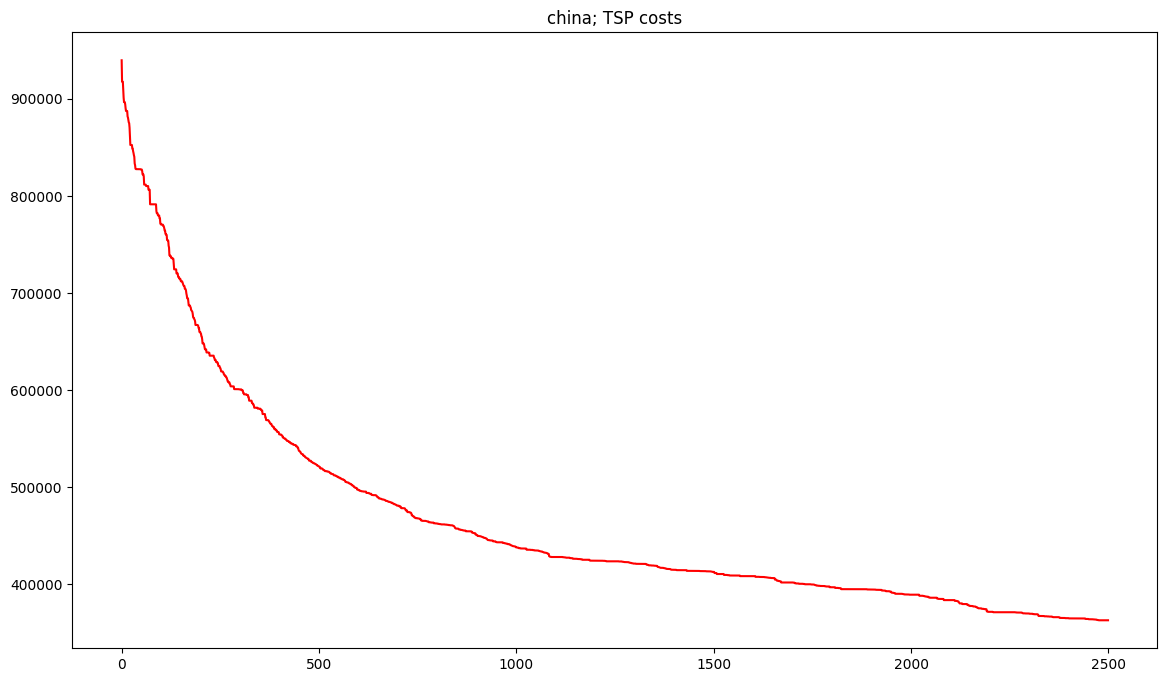

In [28]:
for name in CITIES_LIST:
    CITIES, DIST_MATRIX = read_df(name[0])
    GENERATIONS = adjust_generations(len(CITIES))
    best_tsp, best_cost, history = evolutionary_algorithm(CITIES, DIST_MATRIX)
    TSP_COSTS[name[1]].append(best_cost)

    generate_map(CITIES, best_tsp, name[1], "ea_v1")
    print(f"{name[1]}; final path of {len(best_tsp)-1} steps; total length: {best_cost:.2f}km")
    plot_map(CITIES, best_tsp)
    plot_cost(history, name[1])

### EA with Inver-Over crossover and Inversion mutation

  0%|          | 0/1500 [00:00<?, ?it/s]

italy; final path of 46 steps; total length: 4445.69km


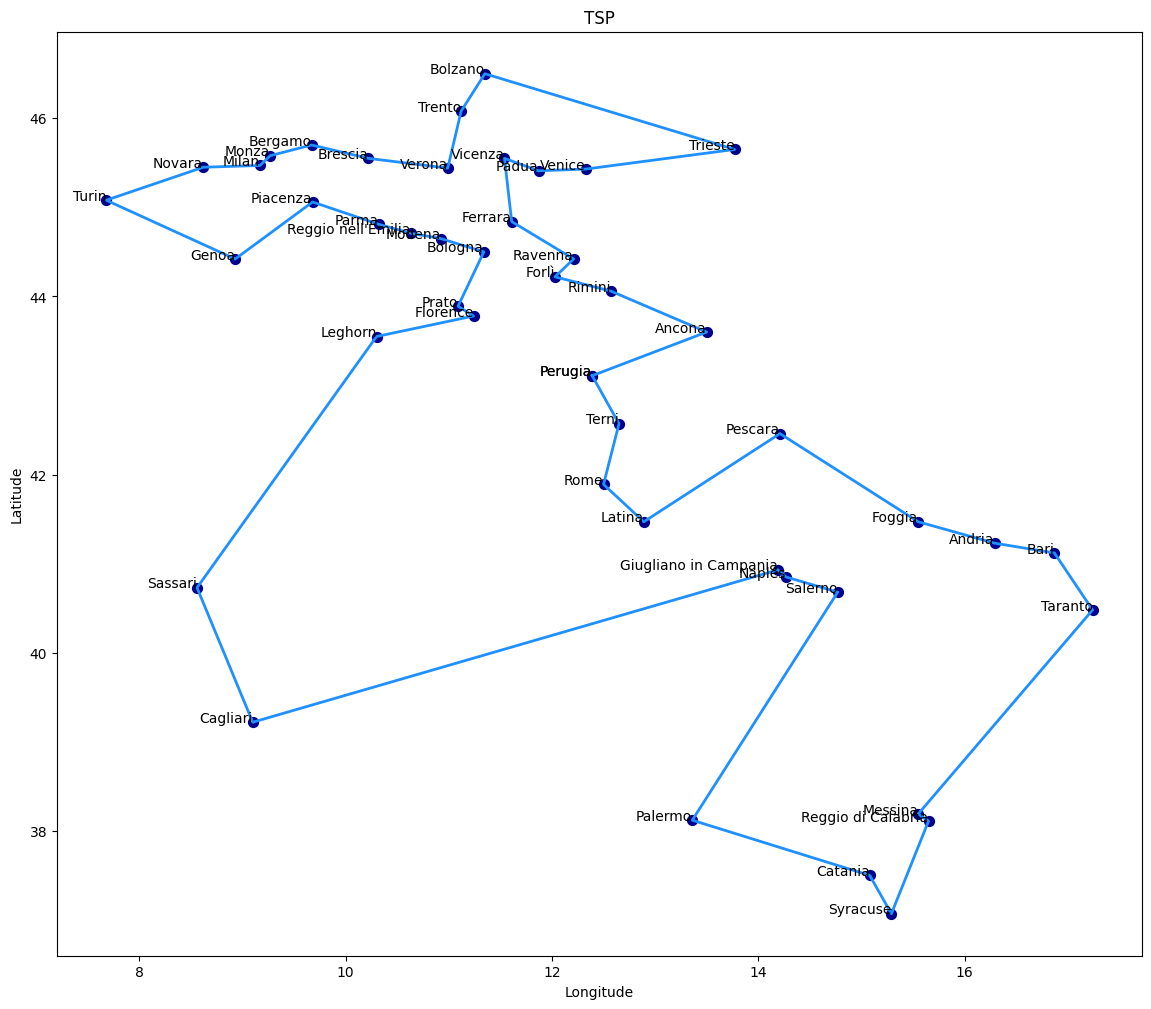

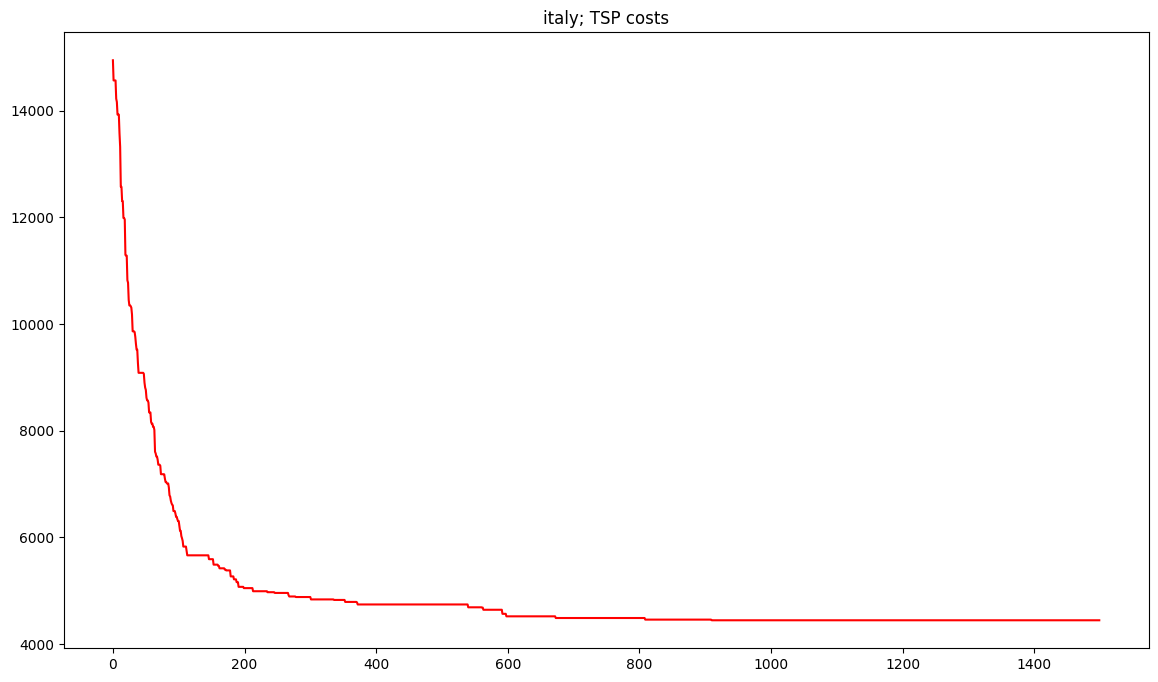

  0%|          | 0/500 [00:00<?, ?it/s]

vanuatu; final path of 8 steps; total length: 1345.54km


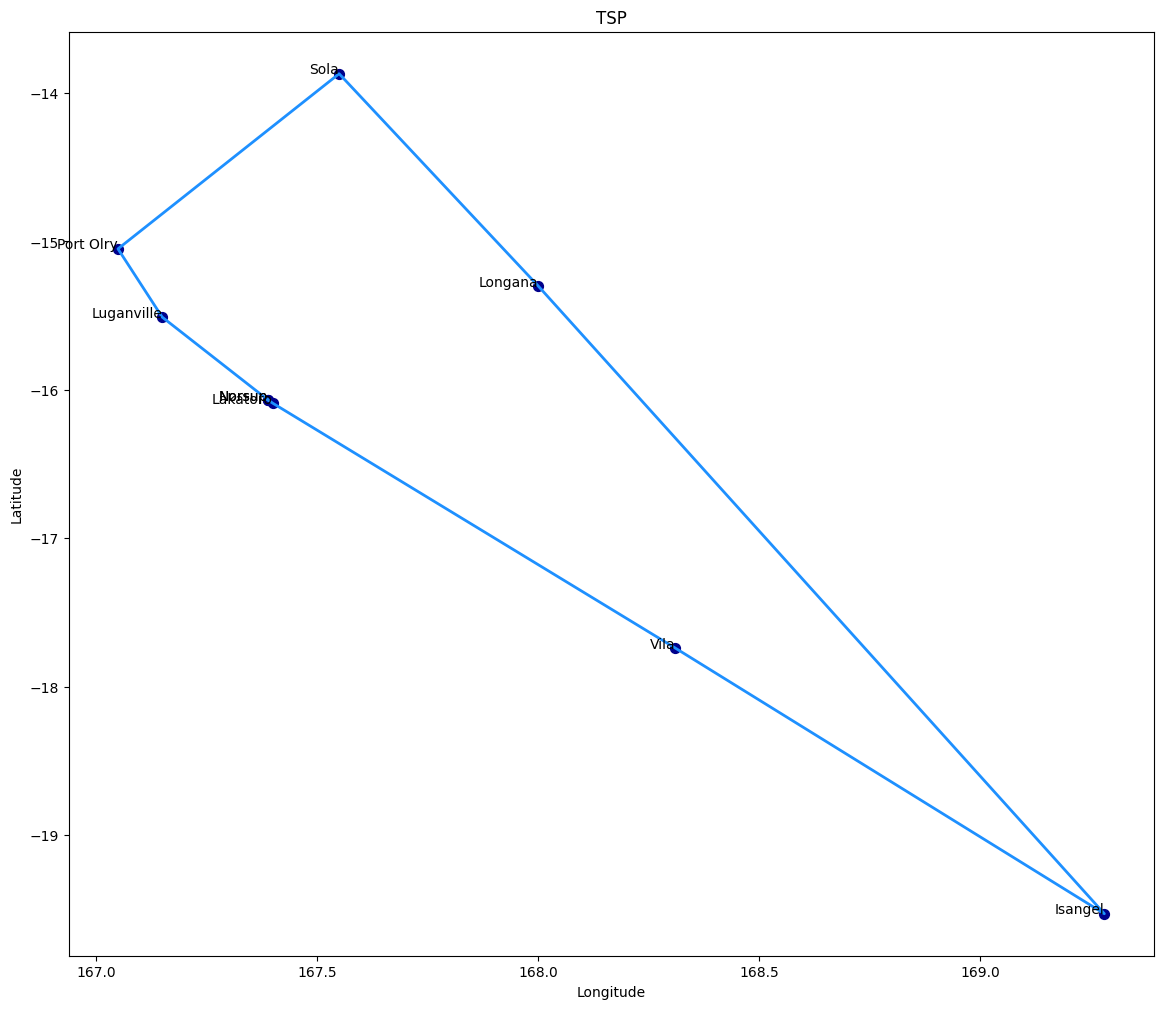

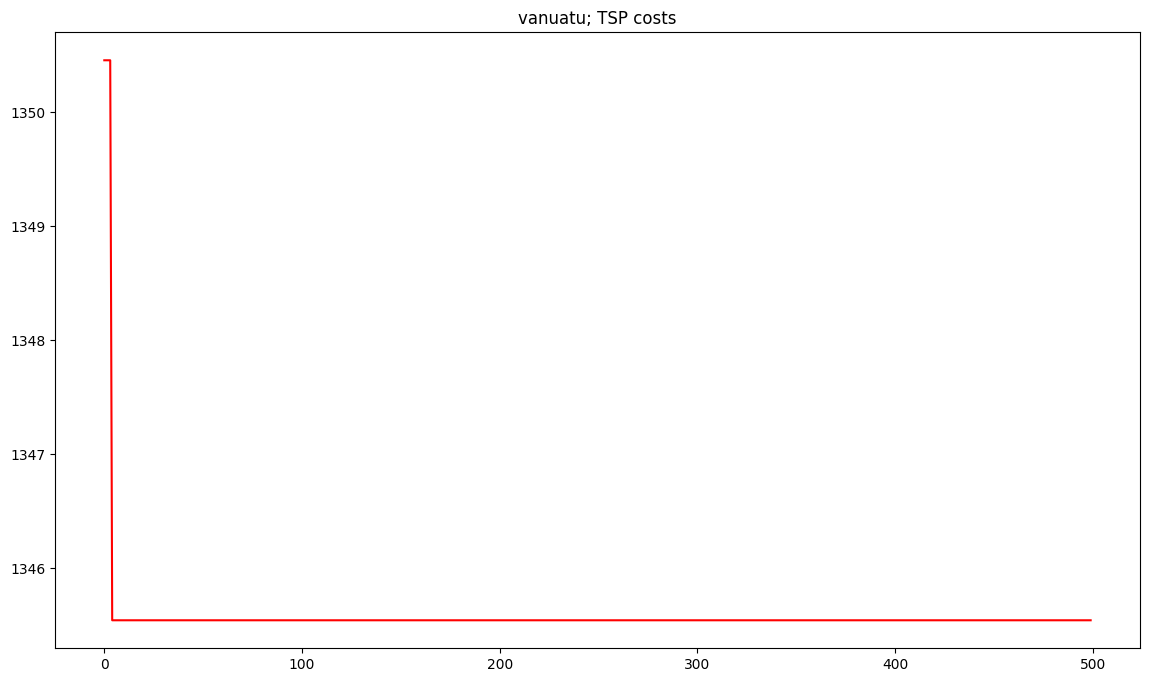

  0%|          | 0/2500 [00:00<?, ?it/s]

russia; final path of 167 steps; total length: 41752.09km


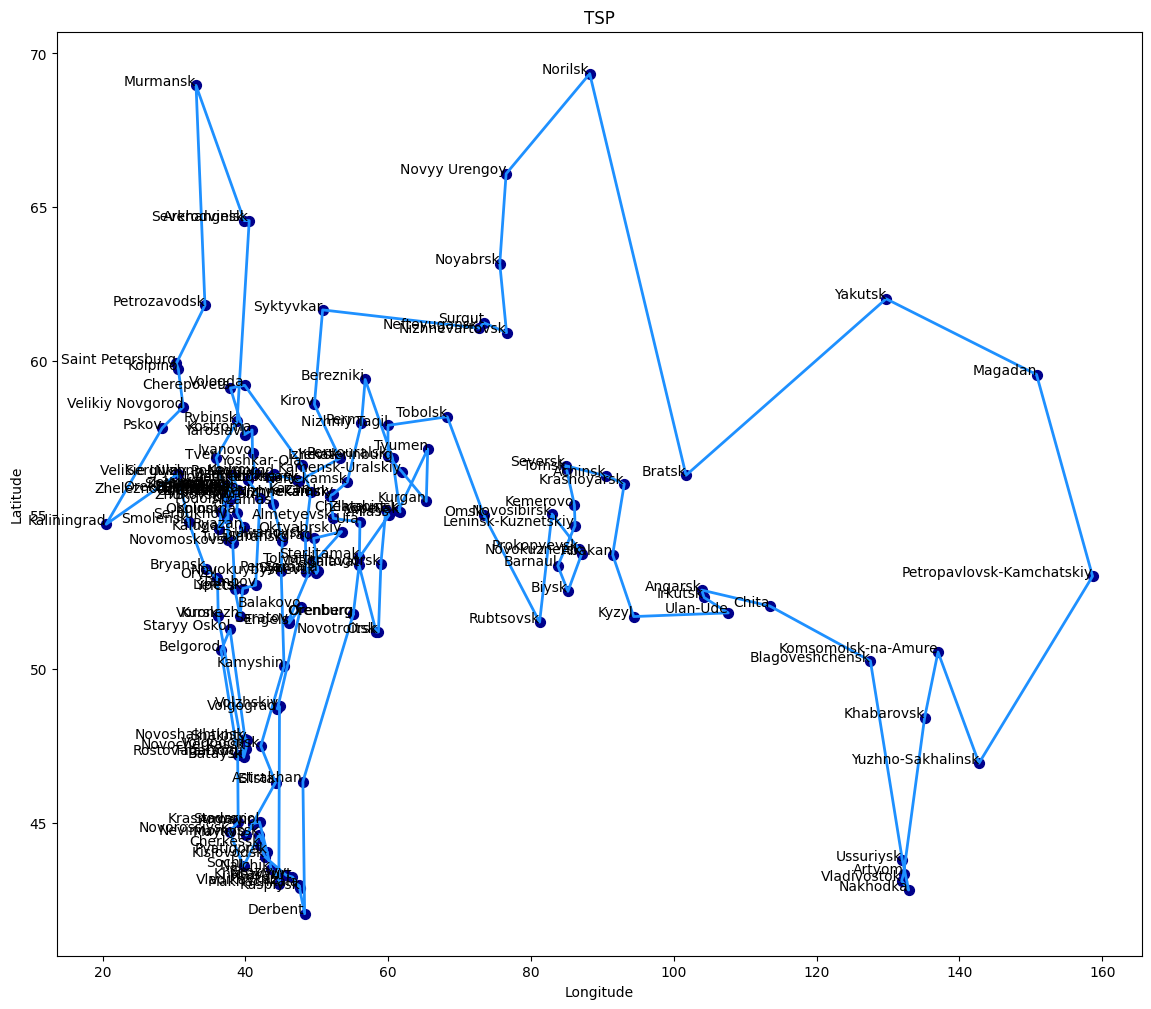

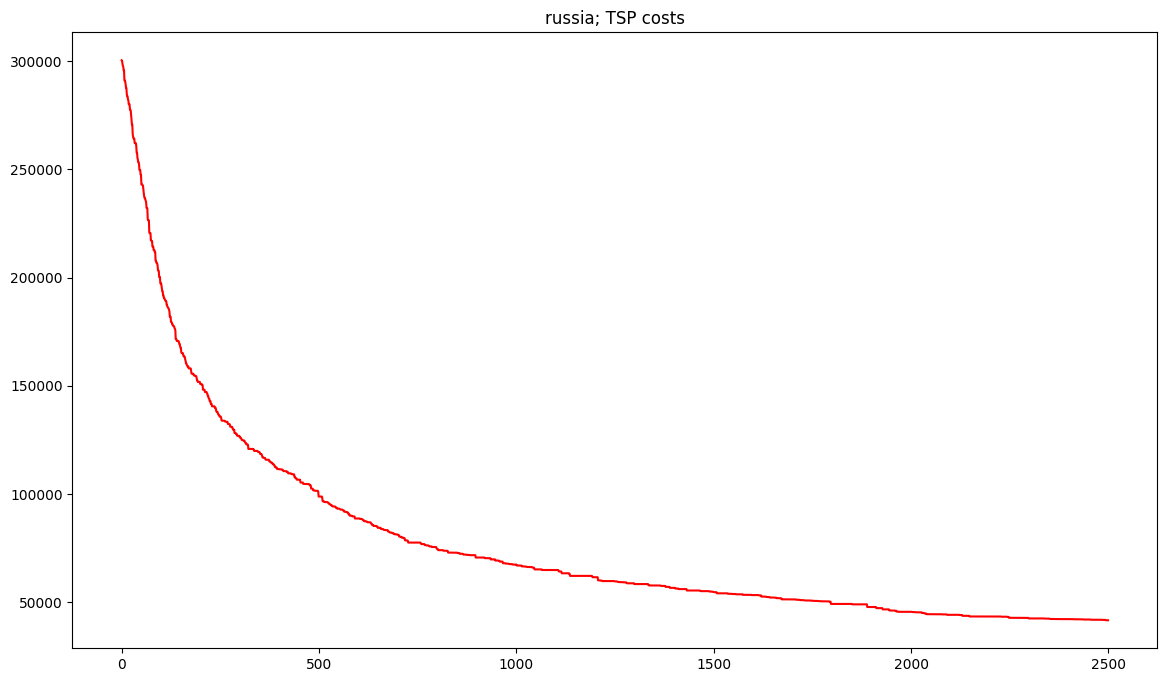

  0%|          | 0/2500 [00:00<?, ?it/s]

us; final path of 326 steps; total length: 175554.41km


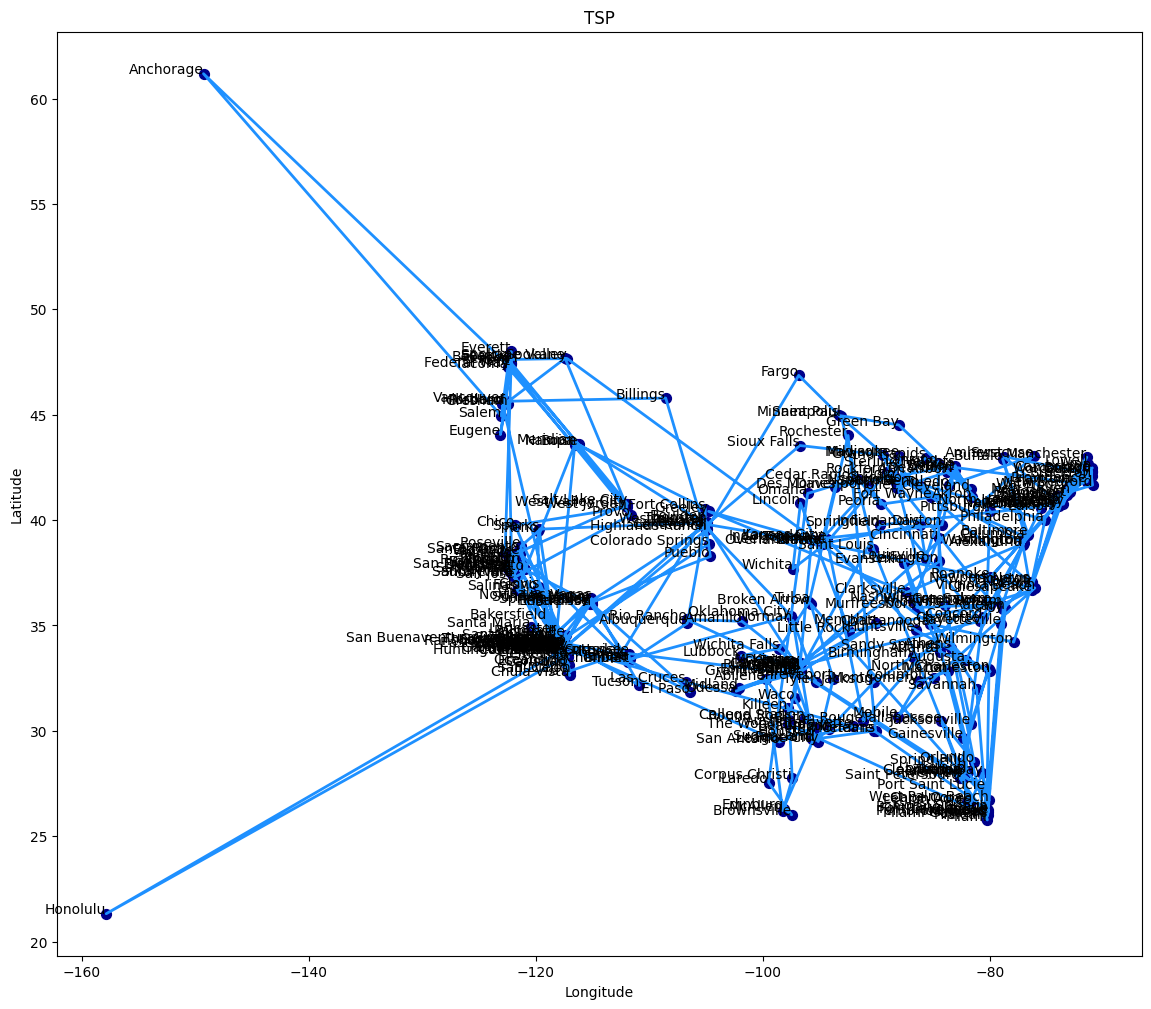

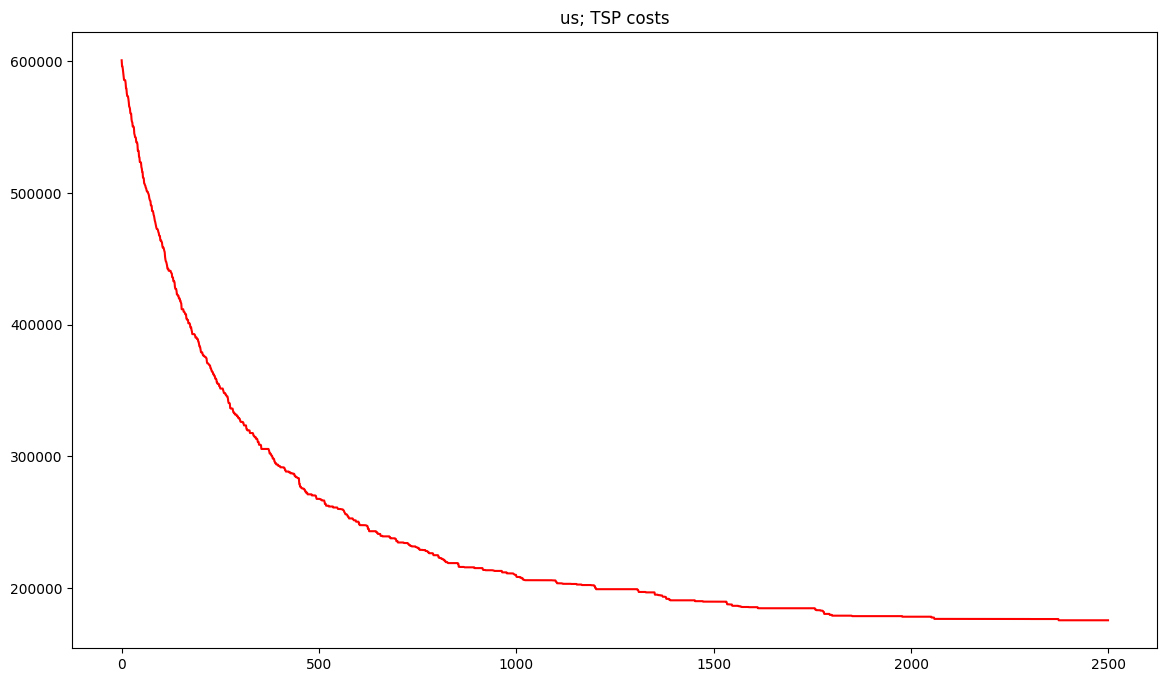

  0%|          | 0/2500 [00:00<?, ?it/s]

china; final path of 726 steps; total length: 438353.81km


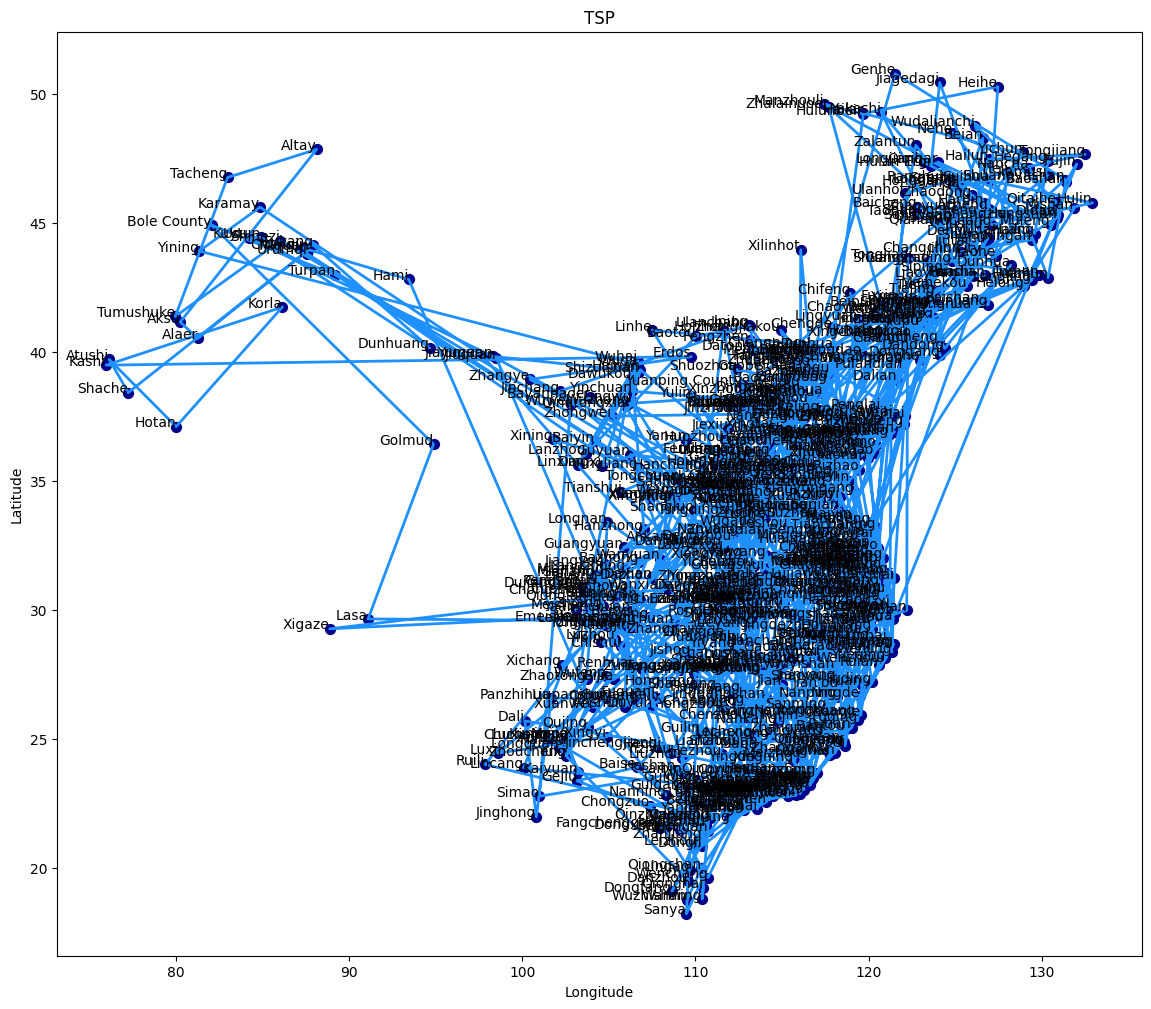

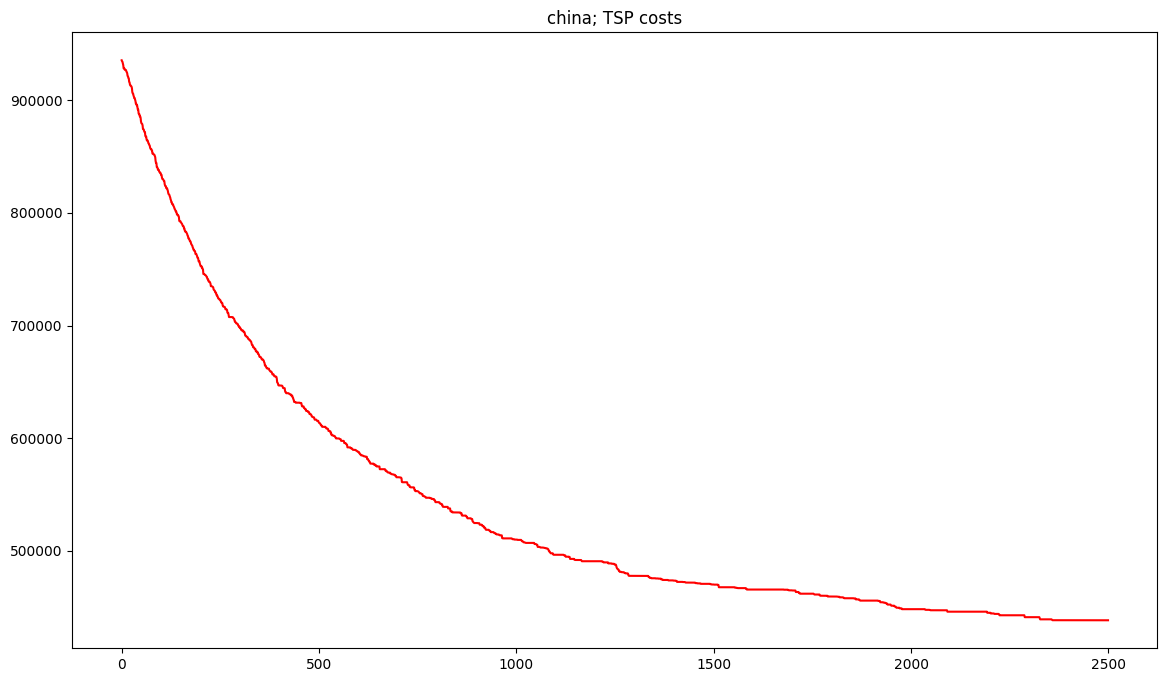

In [29]:
for name in CITIES_LIST:
    CITIES, DIST_MATRIX = read_df(name[0])
    GENERATIONS = adjust_generations(len(CITIES))
    best_tsp, best_cost, history = evolutionary_algorithm(CITIES, DIST_MATRIX, True)
    TSP_COSTS[name[1]].append(best_cost)

    generate_map(CITIES, best_tsp, name[1], "ea_v2")
    print(f"{name[1]}; final path of {len(best_tsp)-1} steps; total length: {best_cost:.2f}km")
    plot_map(CITIES, best_tsp)
    plot_cost(history, name[1])

In [32]:
for country in TSP_COSTS.keys():
    print(country.upper(), ":", sep="")
    print("\tGreedy algorithm:\t", round(TSP_COSTS[country][0], 3), sep="")
    print("\tEA version 1:\t\t", round(TSP_COSTS[country][1], 3), sep="")
    print("\tEA version 2:\t\t", round(TSP_COSTS[country][2], 3), sep="")

ITALY:
	Greedy algorithm:	4436.032
	EA version 1:		5643.244
	EA version 2:		4445.693
VANUATU:
	Greedy algorithm:	1475.528
	EA version 1:		1345.545
	EA version 2:		1345.545
RUSSIA:
	Greedy algorithm:	42334.165
	EA version 1:		67685.216
	EA version 2:		41752.091
US:
	Greedy algorithm:	48050.026
	EA version 1:		167020.429
	EA version 2:		175554.411
CHINA:
	Greedy algorithm:	63962.918
	EA version 1:		362677.202
	EA version 2:		438353.812
